# Assignment 5: Image Stitching

MIDS W281: Computer Vision

## Recommended Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from utils import *

![Hybrid Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_5/teaser.png)

 ### Overview
Remember in class you learned how to compute the homography between two planar surfaces. In this assignment, you will use that knowledge to stitch together the images of the above restaurant advertisement.

 ### Description
 There are two images inside the ***align_images*** directory. You will write Python code to perform the following.

 1. **Homography Computation:** Write a Python function that takes as input two images (source and destination image) and computes the homography from the source to the destination image. You can use the `findHomography` method in OpenCV. The homography calculation requires at least four point correspondences between the two images, which you can select manually. However, with only four points the homography recovery can be prone to noise, so feel free to select more than four point correspondences.
Establishing point correspondences is very important because an error of just a few pixels can produce large errors in the recovered homography. We have provided a set of four hard-coded point correspondences in the code, but you should also try to add more points and compute the homography with your own set of points. You can provide point matches with a mouse-clicking interface such as `ginput`. Display a plot showing the point-correspondences on the two images and print the computed homography.  

2. **Image Bounds:** As the final output image should be large enough to contain both the transformed source image and the destination image, we need to first compute the size of the final image. For this, you will use the corners of the source and destination images i.e `(0, 0, im.shape[1], im.shape[0])` to find the bounds for the final image. Warp the the source corners using the above homography, and combine with the destination corners to compute the final bounds. You can use the `perspectiveTransform` method from Python's OpenCV library to warp the source bounds.    
    ***Hint: The final image bounds can have negative values, which means that the source image, after warping, will lie above and/or left of the (0,0) position in the destination image.***

3. **Image Warping:** In order to stitch the `src` and `dest` images, you need to warp the `src` to the `dest` image first. You will do this warping using the `warp_image_with_bounds` provided to you in utils.py. The function expects the source image, homography, and the final image bounds computed above. The output of the function will be large enough to contain both source and destination images. However, the output image will contain only the source image warped to the destination space and translated so that the left-top of the output image is at (0,0) (remember the negative values in the image bounds).  

4. **Image-pair stitching:** Finally place the destination image into the final output. The output image has been translated so that the left-top of the output image is at (0,0). You will need to shift the destination image by the same amount before placing it in the output image. You can simply replace the pixel values of the output image with destination image (we are not doing any blending at the image seam).  

5. **Image rectification:** Finally, you will rectify the stitched image so that the windows become frontal-parallel. This is the same as was done in the class exercise, where you can assume that each of the two large windows is square. For this part, use the four corners of the window in the stitched image (see above figure) and transform it to the destination points given in the code. Select the points in the correct order. Finally, display and submit the rectified image. You can use the image warping code from above.  

### Deliverables:

- A plot displaying the selected point correspondences between the images
- The computed homography between the images (print the matrix)
- The output image after stitching
- The output image after rectification
- Python code for homography compuation, image stitching, and image rectification

For full credit, please ensure your bounds match at least one of the examples at the top or bottom.

In [15]:
# find the homography between the the src to destination image using the given points
# if you want you can add more point correspondences
def find_homography_manual(img_src_path, img_dst_path):

    img_src = plt.imread(img_src_path)
    img_dst = plt.imread(img_dst_path)

    # get the points on the source image
    pts_src = np.array([[1649.15, 298], [2293.79, 236.60],[2243.19, 2168.90],[1770.98, 2133.52], [1702.04, 294.73], [1702.04, 2067.49], [2061.92, 1920.87], [2051.92, 1431.03]])

    # get the points on the destination image
    pts_dst = np.array([[495, 100], [1135, 131],[1021, 1986],[555,1995], [545.30, 116.68], [484.47, 1928.85], [865.47, 1768.77], [881.48, 1266.10]])

    # visualize the points
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax[0].imshow(img_src)
    ax[0].axis('off')
    ax[0].plot(pts_src[:,0], pts_src[:,1], 'r*', markersize=10)
    ax[1].imshow(img_dst)
    ax[1].axis('off')
    ax[1].plot(pts_dst[:,0], pts_dst[:,1], 'r*', markersize=10)
    plt.show()

    # TODO: compute homography using the pts_src and pts_dst
    # TODO: print the computed homography
    H, status = cv2.findHomography(pts_src, pts_dst)
    print("homography matrix:", H)

    return H


def stitch_images(img_src_path, img_dst_path):


    H = find_homography_manual(img_src_path, img_dst_path)

    # read the images
    img_src = plt.imread(img_src_path)
    img_dst = plt.imread(img_dst_path)

    # TODO: find the bounds of the stitched image
    # hint, use cv2.perspectiveTransform to help you

    # representing the corner points in homogeneous coordinates. [x, y, 1], top-left, top-right, bottom-right, bottom-left
    corners_src = np.array([[0, 0, 1],
                           [img_src.shape[1], 0, 1],
                           [img_src.shape[1], img_src.shape[0], 1],
                           [0, img_src.shape[0], 1]])

    # transfer to dst by H
    corners_dst = cv2.perspectiveTransform(corners_src.reshape(-1, 1, 3), H).reshape(-1, 2)


    # TODO replace this with your calculations for the bounds
    [xmin, ymin, xmax, ymax] = [0,0,0,0]

    # warp the image with bounds
    result = warp_image_with_bounds(img_src, H, [xmin, ymin, xmax, ymax])

    # TODO: put the dest image in the result

    # visualize the result
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    ax.imshow(result)
    ax.axis('off')

    return result


def rectify(img_src_path):

    # mark the 4 points on the window
    pts_src = np.array([[464.48358, 727.9149 ],
                     [2370.2458, 796.1351 ],
                     [2310.8284, 2484.0332 ],
                     [277.4284, 2525.8455 ]]).astype(np.float32)
    pts_dst = np.array([[0, 0], [2000, 0], [2000, 2000], [0, 2000]]).astype(np.float32)
    img_src = plt.imread(img_src_path)

    #TODO: compute homography using pts_src and pts_dst using the cv2.findHomography method

    # TODO: compute the bounds of the output rectified image
    # hint, use cv2.perspectiveTransform to help you

    #TODO: replace this with your calculations for the bounds
    [xmin, ymin, xmax, ymax] = [0, 0, 0, 0]

    # warp the image using the bounds
    result = warp_image_with_bounds(img_src, H, [xmin, ymin, xmax, ymax])

    # visualize the result
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    ax.imshow(result)
    ax.axis('off')

    return result

In [ ]:
# use pinget to get extra point pairs from src and dst image.

img_src_path = 'align_images/src.png'
img_dst_path = 'align_images/dest.png'
img_src = plt.imread(img_src_path)
img_dst = plt.imread(img_dst_path)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.imshow(img_src)
ax.axis('off')
plt.show()
points = plt.ginput(2)
print("Clicked points:", points)
plt.close()

# No interactive window pop-up. Run it locally,
# corner of the window from src: [(1702.0404946811987, 294.7369640409843), (1702.0404946811987, 2067.4916465444107)]
# cross of the tiles from src [(2061.9230242119693, 1920.8728382170598), (2051.9262872805593, 1431.032728577955)]
# corner of the window from dst [(545.3072505384062, 116.68305814788255), (484.47451543431407, 1928.858219669778)]
# cross of the tiles from dst [(865.4795405599425, 1768.7720746590096), (881.4881550610194, 1266.1015793251977)]

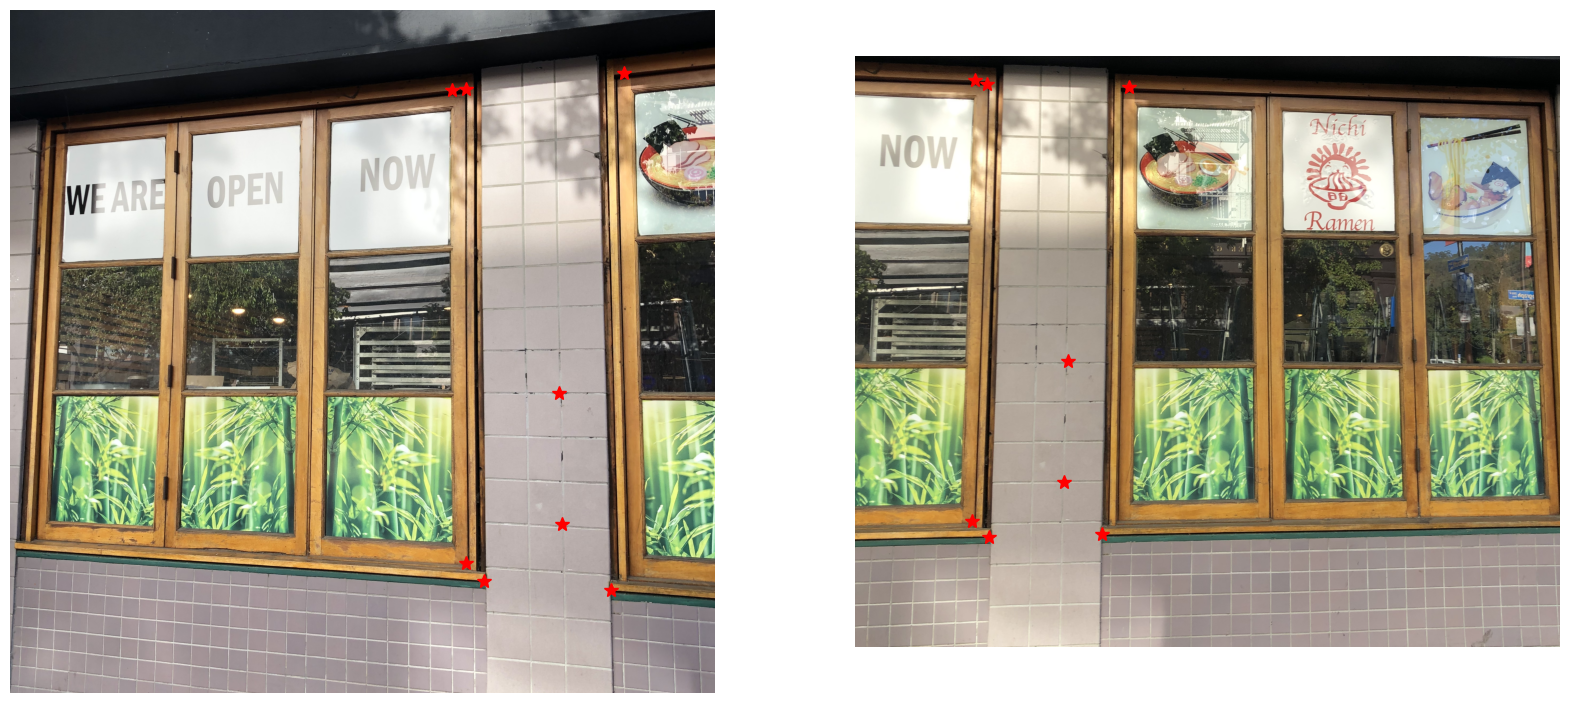

homography matrix: [[ 1.54640114e+00 -4.89732250e-02 -1.88712456e+03]
 [ 2.37681482e-01  1.37220009e+00 -6.68481296e+02]
 [ 1.94982041e-04 -1.58131454e-06  1.00000000e+00]]


In [16]:
img_src_path = 'align_images/src.png'
img_dst_path = 'align_images/dest.png'

H = find_homography_manual(img_src_path, img_dst_path)

In [21]:
img_src_path = 'align_images/src.png'
img_dst_path = 'align_images/dest.png'
img_src = plt.imread(img_src_path)
img_dst = plt.imread(img_dst_path)

    # TODO: find the bounds of the stitched image
    # hint, use cv2.perspectiveTransform to help you

    # representing the corner points in homogeneous coordinates. [x, y, 1], top-left, top-right, bottom-right, bottom-left
# Define corners of the source image in homogeneous coordinates
corners_src = np.array([[0, 0, 1],
                        [img_src.shape[1], 0, 1],
                        [img_src.shape[1], img_src.shape[0], 1],

                        [0, img_src.shape[0], 1]], dtype=np.float32)

# Reshape corners_src for perspectiveTransform
corners_src_reshaped = corners_src[:, :2].reshape(-1, 1, 2)

# Use homography matrix to transform corner points
corners_dst_reshaped = cv2.perspectiveTransform(corners_src_reshaped, H)

# Reshape corners_dst to final shape
corners_dst = corners_dst_reshaped.reshape(-1, 2)

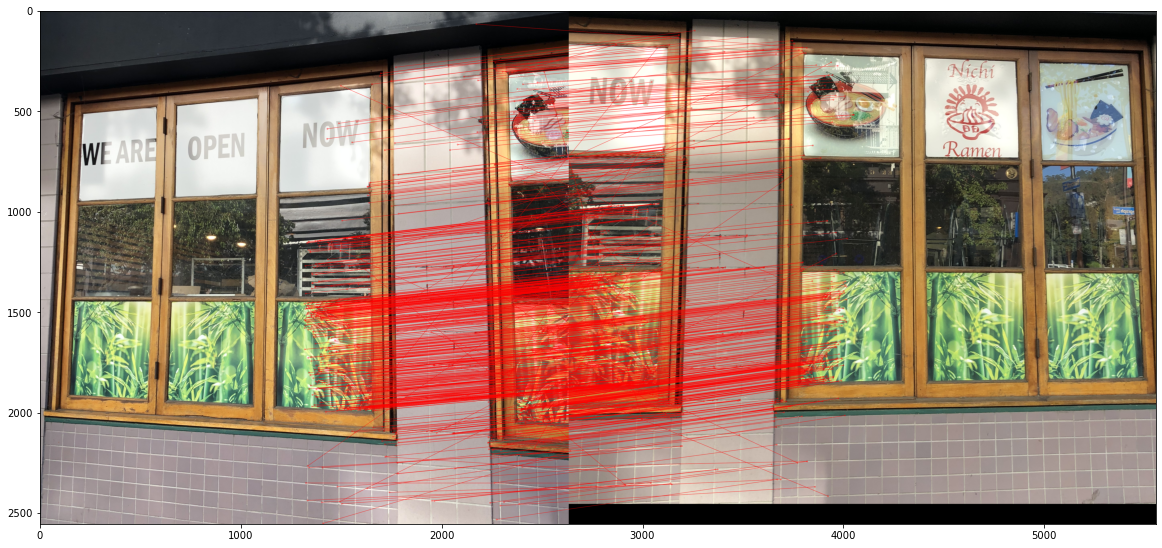

[[ 1.42573268e+00 -5.49166905e-02 -1.69650842e+03]
 [ 1.93565713e-01  1.29508514e+00 -5.66473497e+02]
 [ 1.60121109e-04 -5.02200959e-06  1.00000000e+00]]


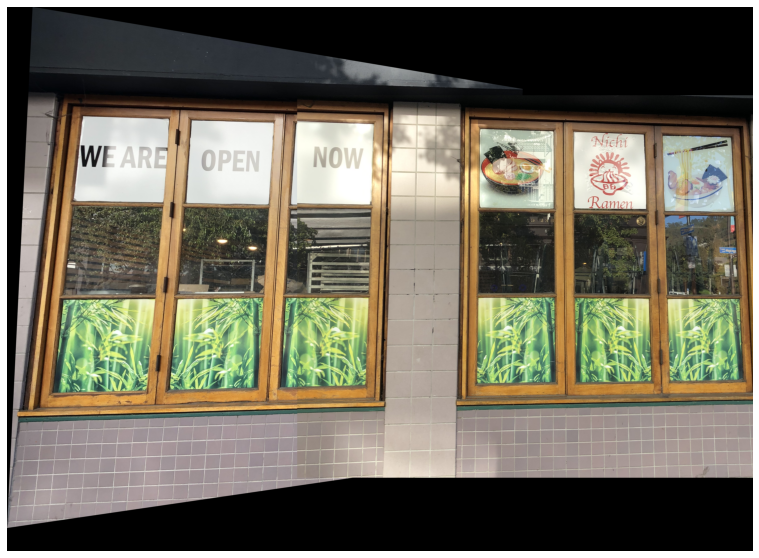

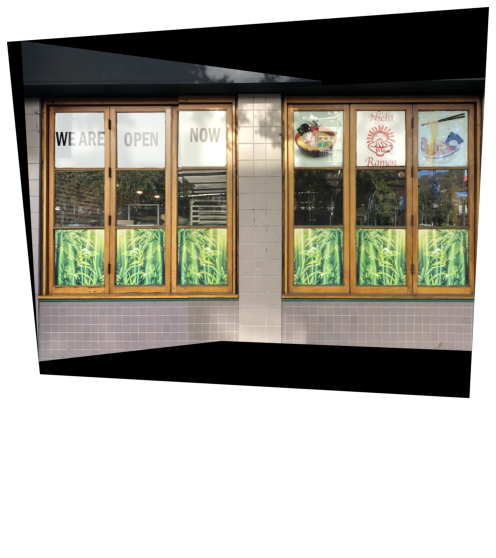

In [ ]:
img_src_path = 'align_images\src.png'
img_dst_path = 'align_images\dest.png'
stitched_path = 'deliverable\stitched.png'
rectified_path = 'deliverable\\rectified.png'

# TODO: complete the code for image stitching
out = stitch_images(img_src_path, img_dst_path)
plt.imsave(stitched_path, out)


# TODO: complete the code for image rectification
rect = rectify(stitched_path)
plt.imsave(rectified_path, rect)